In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=0b8ceef8de05563851ea50f41f8096efcee1ddde42b5d51d3245400cde269557
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/d

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Check for panoptic segmentation

In [ ]:
# Panoptic classes

[{"supercategory": "person", "color": [220, 20, 60], "isthing": 1, "id": 1, "name": "person"}, 
 {"supercategory": "vehicle", "color": [119, 11, 32], "isthing": 1, "id": 2, "name": "bicycle"}, 
 {"supercategory": "vehicle", "color": [0, 0, 142], "isthing": 1, "id": 3, "name": "car"}, 
 {"supercategory": "vehicle", "color": [0, 0, 230], "isthing": 1, "id": 4, "name": "motorcycle"}, 
 {"supercategory": "vehicle", "color": [106, 0, 228], "isthing": 1, "id": 5, "name": "airplane"}, 
 {"supercategory": "vehicle", "color": [0, 60, 100], "isthing": 1, "id": 6, "name": "bus"}, 
 {"supercategory": "vehicle", "color": [0, 80, 100], "isthing": 1, "id": 7, "name": "train"}, 
 {"supercategory": "vehicle", "color": [0, 0, 70], "isthing": 1, "id": 8, "name": "truck"}, 
 {"supercategory": "vehicle", "color": [0, 0, 192], "isthing": 1, "id": 9, "name": "boat"}, 
 {"supercategory": "outdoor", "color": [250, 170, 30], "isthing": 1, "id": 10, "name": "traffic light"}, 
 {"supercategory": "outdoor", "color": [100, 170, 30], "isthing": 1, "id": 11, "name": "fire hydrant"}, 
 {"supercategory": "outdoor", "color": [220, 220, 0], "isthing": 1, "id": 13, "name": "stop sign"}, 
 {"supercategory": "outdoor", "color": [175, 116, 175], "isthing": 1, "id": 14, "name": "parking meter"}, 
 {"supercategory": "outdoor", "color": [250, 0, 30], "isthing": 1, "id": 15, "name": "bench"}, 
 {"supercategory": "animal", "color": [165, 42, 42], "isthing": 1, "id": 16, "name": "bird"}, 
 {"supercategory": "animal", "color": [255, 77, 255], "isthing": 1, "id": 17, "name": "cat"}, 
 {"supercategory": "animal", "color": [0, 226, 252], "isthing": 1, "id": 18, "name": "dog"}, 
 {"supercategory": "animal", "color": [182, 182, 255], "isthing": 1, "id": 19, "name": "horse"},
 {"supercategory": "animal", "color": [0, 82, 0], "isthing": 1, "id": 20, "name": "sheep"}, 
 {"supercategory": "animal", "color": [120, 166, 157], "isthing": 1, "id": 21, "name": "cow"}, 
 {"supercategory": "animal", "color": [110, 76, 0], "isthing": 1, "id": 22, "name": "elephant"}, 
 {"supercategory": "animal", "color": [174, 57, 255], "isthing": 1, "id": 23, "name": "bear"}, 
 {"supercategory": "animal", "color": [199, 100, 0], "isthing": 1, "id": 24, "name": "zebra"}, 
 {"supercategory": "animal", "color": [72, 0, 118], "isthing": 1, "id": 25, "name": "giraffe"}, 
 {"supercategory": "accessory", "color": [255, 179, 240], "isthing": 1, "id": 27, "name": "backpack"}, 
 {"supercategory": "accessory", "color": [0, 125, 92], "isthing": 1, "id": 28, "name": "umbrella"}, 
 {"supercategory": "accessory", "color": [209, 0, 151], "isthing": 1, "id": 31, "name": "handbag"}, 
 {"supercategory": "accessory", "color": [188, 208, 182], "isthing": 1, "id": 32, "name": "tie"}, 
 {"supercategory": "accessory", "color": [0, 220, 176], "isthing": 1, "id": 33, "name": "suitcase"}, 
 {"supercategory": "sports", "color": [255, 99, 164], "isthing": 1, "id": 34, "name": "frisbee"}, 
 {"supercategory": "sports", "color": [92, 0, 73], "isthing": 1, "id": 35, "name": "skis"}, 
 {"supercategory": "sports", "color": [133, 129, 255], "isthing": 1, "id": 36, "name": "snowboard"}, 
 {"supercategory": "sports", "color": [78, 180, 255], "isthing": 1, "id": 37, "name": "sports ball"}, 
 {"supercategory": "sports", "color": [0, 228, 0], "isthing": 1, "id": 38, "name": "kite"}, 
 {"supercategory": "sports", "color": [174, 255, 243], "isthing": 1, "id": 39, "name": "baseball bat"}, 
 {"supercategory": "sports", "color": [45, 89, 255], "isthing": 1, "id": 40, "name": "baseball glove"}, 
 {"supercategory": "sports", "color": [134, 134, 103], "isthing": 1, "id": 41, "name": "skateboard"}, 
 {"supercategory": "sports", "color": [145, 148, 174], "isthing": 1, "id": 42, "name": "surfboard"}, 
 {"supercategory": "sports", "color": [255, 208, 186], "isthing": 1, "id": 43, "name": "tennis racket"}, 
 {"supercategory": "kitchen", "color": [197, 226, 255], "isthing": 1, "id": 44, "name": "bottle"}, 
 {"supercategory": "kitchen", "color": [171, 134, 1], "isthing": 1, "id": 46, "name": "wine glass"}, 
 {"supercategory": "kitchen", "color": [109, 63, 54], "isthing": 1, "id": 47, "name": "cup"}, 
 {"supercategory": "kitchen", "color": [207, 138, 255], "isthing": 1, "id": 48, "name": "fork"}, 
 {"supercategory": "kitchen", "color": [151, 0, 95], "isthing": 1, "id": 49, "name": "knife"}, 
 {"supercategory": "kitchen", "color": [9, 80, 61], "isthing": 1, "id": 50, "name": "spoon"}, 
 {"supercategory": "kitchen", "color": [84, 105, 51], "isthing": 1, "id": 51, "name": "bowl"}, 
 {"supercategory": "food", "color": [74, 65, 105], "isthing": 1, "id": 52, "name": "banana"}, 
 {"supercategory": "food", "color": [166, 196, 102], "isthing": 1, "id": 53, "name": "apple"}, 
 {"supercategory": "food", "color": [208, 195, 210], "isthing": 1, "id": 54, "name": "sandwich"}, 
 {"supercategory": "food", "color": [255, 109, 65], "isthing": 1, "id": 55, "name": "orange"}, 
 {"supercategory": "food", "color": [0, 143, 149], "isthing": 1, "id": 56, "name": "broccoli"}, 
 {"supercategory": "food", "color": [179, 0, 194], "isthing": 1, "id": 57, "name": "carrot"}, 
 {"supercategory": "food", "color": [209, 99, 106], "isthing": 1, "id": 58, "name": "hot dog"}, 
 {"supercategory": "food", "color": [5, 121, 0], "isthing": 1, "id": 59, "name": "pizza"}, 
 {"supercategory": "food", "color": [227, 255, 205], "isthing": 1, "id": 60, "name": "donut"}, 
 {"supercategory": "food", "color": [147, 186, 208], "isthing": 1, "id": 61, "name": "cake"}, 
 {"supercategory": "furniture", "color": [153, 69, 1], "isthing": 1, "id": 62, "name": "chair"}, 
 {"supercategory": "furniture", "color": [3, 95, 161], "isthing": 1, "id": 63, "name": "couch"}, 
 {"supercategory": "furniture", "color": [163, 255, 0], "isthing": 1, "id": 64, "name": "potted plant"}, 
 {"supercategory": "furniture", "color": [119, 0, 170], "isthing": 1, "id": 65, "name": "bed"}, 
 {"supercategory": "furniture", "color": [0, 182, 199], "isthing": 1, "id": 67, "name": "dining table"}, 
 {"supercategory": "furniture", "color": [0, 165, 120], "isthing": 1, "id": 70, "name": "toilet"}, 
 {"supercategory": "electronic", "color": [183, 130, 88], "isthing": 1, "id": 72, "name": "tv"}, 
 {"supercategory": "electronic", "color": [95, 32, 0], "isthing": 1, "id": 73, "name": "laptop"}, 
 {"supercategory": "electronic", "color": [130, 114, 135], "isthing": 1, "id": 74, "name": "mouse"}, 
 {"supercategory": "electronic", "color": [110, 129, 133], "isthing": 1, "id": 75, "name": "remote"}, 
 {"supercategory": "electronic", "color": [166, 74, 118], "isthing": 1, "id": 76, "name": "keyboard"}, 
 {"supercategory": "electronic", "color": [219, 142, 185], "isthing": 1, "id": 77, "name": "cell phone"}, 
 {"supercategory": "appliance", "color": [79, 210, 114], "isthing": 1, "id": 78, "name": "microwave"}, 
 {"supercategory": "appliance", "color": [178, 90, 62], "isthing": 1, "id": 79, "name": "oven"}, 
 {"supercategory": "appliance", "color": [65, 70, 15], "isthing": 1, "id": 80, "name": "toaster"}, 
 {"supercategory": "appliance", "color": [127, 167, 115], "isthing": 1, "id": 81, "name": "sink"}, 
 {"supercategory": "appliance", "color": [59, 105, 106], "isthing": 1, "id": 82, "name": "refrigerator"}, 
 {"supercategory": "indoor", "color": [142, 108, 45], "isthing": 1, "id": 84, "name": "book"}, 
 {"supercategory": "indoor", "color": [196, 172, 0], "isthing": 1, "id": 85, "name": "clock"}, 
 {"supercategory": "indoor", "color": [95, 54, 80], "isthing": 1, "id": 86, "name": "vase"}, 
 {"supercategory": "indoor", "color": [128, 76, 255], "isthing": 1, "id": 87, "name": "scissors"}, 
 {"supercategory": "indoor", "color": [201, 57, 1], "isthing": 1, "id": 88, "name": "teddy bear"}, 
 {"supercategory": "indoor", "color": [246, 0, 122], "isthing": 1, "id": 89, "name": "hair drier"}, 
 {"supercategory": "indoor", "color": [191, 162, 208], "isthing": 1, "id": 90, "name": "toothbrush"}, 
 {"supercategory": "textile", "color": [255, 255, 128], "isthing": 0, "id": 92, "name": "banner"}, 
 {"supercategory": "textile", "color": [147, 211, 203], "isthing": 0, "id": 93, "name": "blanket"}, 
 {"supercategory": "building", "color": [150, 100, 100], "isthing": 0, "id": 95, "name": "bridge"}, 
 {"supercategory": "raw-material", "color": [168, 171, 172], "isthing": 0, "id": 100, "name": "cardboard"}, 
 {"supercategory": "furniture-stuff", "color": [146, 112, 198], "isthing": 0, "id": 107, "name": "counter"}, 
 {"supercategory": "textile", "color": [210, 170, 100], "isthing": 0, "id": 109, "name": "curtain"}, 
 {"supercategory": "furniture-stuff", "color": [92, 136, 89], "isthing": 0, "id": 112, "name": "door-stuff"}, 
 {"supercategory": "floor", "color": [218, 88, 184], "isthing": 0, "id": 118, "name": "floor-wood"}, 
 {"supercategory": "plant", "color": [241, 129, 0], "isthing": 0, "id": 119, "name": "flower"}, 
 {"supercategory": "food-stuff", "color": [217, 17, 255], "isthing": 0, "id": 122, "name": "fruit"}, 
 {"supercategory": "ground", "color": [124, 74, 181], "isthing": 0, "id": 125, "name": "gravel"}, 
 {"supercategory": "building", "color": [70, 70, 70], "isthing": 0, "id": 128, "name": "house"}, 
 {"supercategory": "furniture-stuff", "color": [255, 228, 255], "isthing": 0, "id": 130, "name": "light"}, 
 {"supercategory": "furniture-stuff", "color": [154, 208, 0], "isthing": 0, "id": 133, "name": "mirror-stuff"}, 
 {"supercategory": "structural", "color": [193, 0, 92], "isthing": 0, "id": 138, "name": "net"},
 {"supercategory": "textile", "color": [76, 91, 113], "isthing": 0, "id": 141, "name": "pillow"}, 
 {"supercategory": "ground", "color": [255, 180, 195], "isthing": 0, "id": 144, "name": "platform"}, 
 {"supercategory": "ground", "color": [106, 154, 176], "isthing": 0, "id": 145, "name": "playingfield"},
 {"supercategory": "ground", "color": [230, 150, 140], "isthing": 0, "id": 147, "name": "railroad"}, 
 {"supercategory": "water", "color": [60, 143, 255], "isthing": 0, "id": 148, "name": "river"}, 
 {"supercategory": "ground", "color": [128, 64, 128], "isthing": 0, "id": 149, "name": "road"}, 
 {"supercategory": "building", "color": [92, 82, 55], "isthing": 0, "id": 151, "name": "roof"}, 
 {"supercategory": "ground", "color": [254, 212, 124], "isthing": 0, "id": 154, "name": "sand"}, 
 {"supercategory": "water", "color": [73, 77, 174], "isthing": 0, "id": 155, "name": "sea"}, 
 {"supercategory": "furniture-stuff", "color": [255, 160, 98], "isthing": 0, "id": 156, "name": "shelf"}, 
 {"supercategory": "ground", "color": [255, 255, 255], "isthing": 0, "id": 159, "name": "snow"}, 
 {"supercategory": "furniture-stuff", "color": [104, 84, 109], "isthing": 0, "id": 161, "name": "stairs"}, 
 {"supercategory": "building", "color": [169, 164, 131], "isthing": 0, "id": 166, "name": "tent"}, 
 {"supercategory": "textile", "color": [225, 199, 255], "isthing": 0, "id": 168, "name": "towel"}, 
 {"supercategory": "wall", "color": [137, 54, 74], "isthing": 0, "id": 171, "name": "wall-brick"}, 
 {"supercategory": "wall", "color": [135, 158, 223], "isthing": 0, "id": 175, "name": "wall-stone"}, 
 {"supercategory": "wall", "color": [7, 246, 231], "isthing": 0, "id": 176, "name": "wall-tile"}, 
 {"supercategory": "wall", "color": [107, 255, 200], "isthing": 0, "id": 177, "name": "wall-wood"}, 
 {"supercategory": "water", "color": [58, 41, 149], "isthing": 0, "id": 178, "name": "water-other"}, 
 {"supercategory": "window", "color": [183, 121, 142], "isthing": 0, "id": 180, "name": "window-blind"}, 
 {"supercategory": "window", "color": [255, 73, 97], "isthing": 0, "id": 181, "name": "window-other"}, 
 {"supercategory": "plant", "color": [107, 142, 35], "isthing": 0, "id": 184, "name": "tree-merged"}, 
 {"supercategory": "structural", "color": [190, 153, 153], "isthing": 0, "id": 185, "name": "fence-merged"}, 
 {"supercategory": "ceiling", "color": [146, 139, 141], "isthing": 0, "id": 186, "name": "ceiling-merged"}, 
 {"supercategory": "sky", "color": [70, 130, 180], "isthing": 0, "id": 187, "name": "sky-other-merged"}, 
 {"supercategory": "furniture-stuff", "color": [134, 199, 156], "isthing": 0, "id": 188, "name": "cabinet-merged"}, 
 {"supercategory": "furniture-stuff", "color": [209, 226, 140], "isthing": 0, "id": 189, "name": "table-merged"}, 
 {"supercategory": "floor", "color": [96, 36, 108], "isthing": 0, "id": 190, "name": "floor-other-merged"}, 
 {"supercategory": "ground", "color": [96, 96, 96], "isthing": 0, "id": 191, "name": "pavement-merged"}, 
 {"supercategory": "solid", "color": [64, 170, 64], "isthing": 0, "id": 192, "name": "mountain-merged"}, 
 {"supercategory": "plant", "color": [152, 251, 152], "isthing": 0, "id": 193, "name": "grass-merged"}, 
 {"supercategory": "ground", "color": [208, 229, 228], "isthing": 0, "id": 194, "name": "dirt-merged"}, 
 {"supercategory": "raw-material", "color": [206, 186, 171], "isthing": 0, "id": 195, "name": "paper-merged"}, 
 {"supercategory": "food-stuff", "color": [152, 161, 64], "isthing": 0, "id": 196, "name": "food-other-merged"}, 
 {"supercategory": "building", "color": [116, 112, 0], "isthing": 0, "id": 197, "name": "building-other-merged"}, 
 {"supercategory": "solid", "color": [0, 114, 143], "isthing": 0, "id": 198, "name": "rock-merged"},
 {"supercategory": "wall", "color": [102, 102, 156], "isthing": 0, "id": 199, "name": "wall-other-merged"}, 
 {"supercategory": "textile", "color": [250, 141, 255], "isthing": 0, "id": 200, "name": "rug-merged"}]


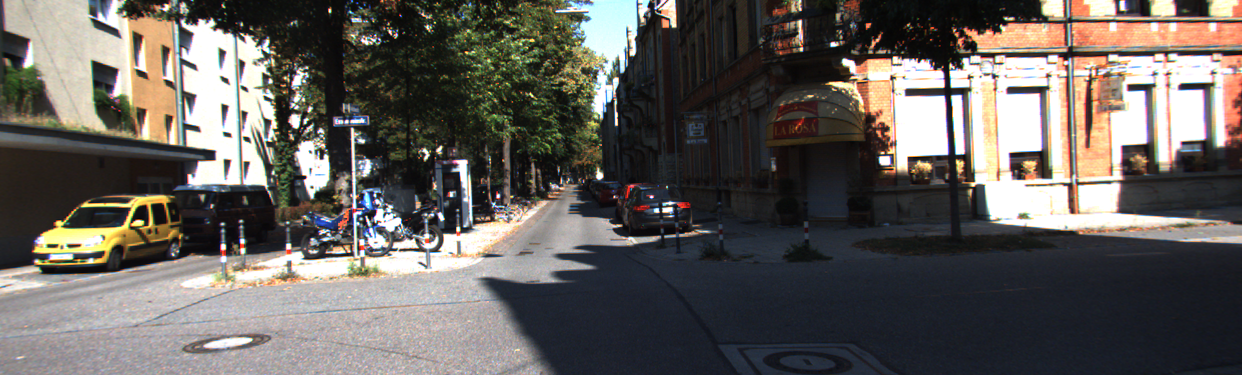

In [ ]:
im = cv2.imread("/content/000008.png")
#im = cv2.resize(im, (640, 480), interpolation= cv2.INTER_AREA)
cv2_imshow(im)
cfg = get_cfg()

In [ ]:
# Panoptic Segmentation
# Ref: https://youtu.be/Pb3opEFP94U
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

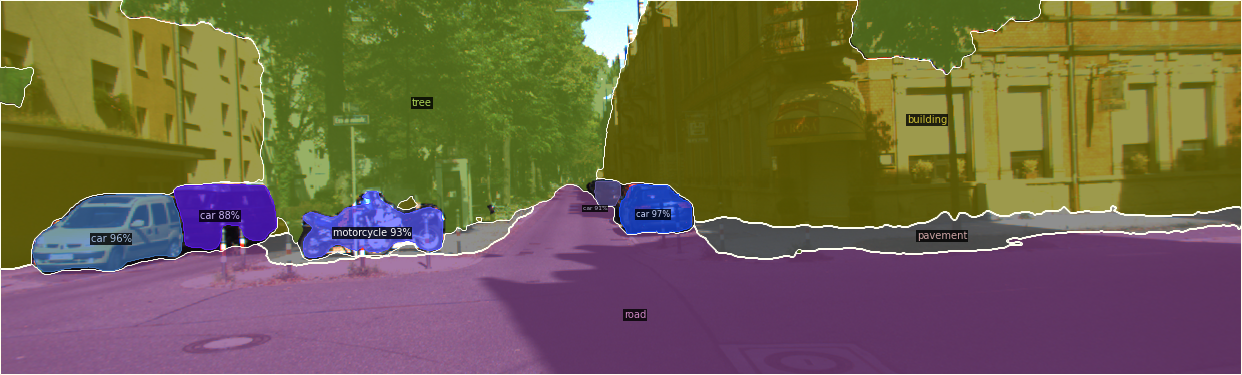

In [ ]:
# Panoptic Segmentation Visualizer
# We can use `Visualizer` to draw the predictions on the image.
predictions, segmentInfo = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
# Uncomment to filter out specific segments
# out = v.draw_panoptic_seg_predictions(predictions.to("cpu"), list(filter(lambda x: x['category_id'] == 17, segmentInfo)), area_threshold=.1)
out = v.draw_panoptic_seg_predictions(predictions.to("cpu"), segmentInfo, area_threshold=.1)
cv2_imshow(out.get_image()[:, :, ::-1])